<div style="display: inline-block; text-align: center; float: left; margin-right: 25px;">
    <a href="https://www.linkedin.com/in/jason-wittenauer-28026110/"><img src="bin/Profile.png" align=left></a>
</div>

# Introduction to Geographical Time Series Prediction with Crime Data in R, SQL, and Tableau
1/18/2020

<img src="bin/Crime Scene.jpg">

## In this tutorial you will learn how to prepare geographical data for time series predictions.

When reviewing geographical data, it can be difficult to prepare the data for an analysis. There are specific algorithms that can be used, but can be limited in what they do. An easy alternative to use is splitting up the data into grids and then adding a time point for each grid point. This will frame up the data in a way that is easy to understand and use for modeling. However, it does create an issue with the size of the data set. 

A five year crime data set can easily consist of 250,000 records. Once that is extrapolated into a time series grid on of a city, it can easily hit 75 million records. When dealing with data of this size, it is helpful to use a database to cleanse the data before sending it to a modeling script. The steps we will follow are listed below:

 - Importing data into a SQL Server database.
 - Cleansing and grouping data into a map grid.
 - Adding time data points to the set of grid data and filling in the gaps where no crimes occurred.
 - Importing the data into R
 - Running an XGBoost model to determine where crimes will occur on a specific day
 
At the end, we will discuss the next steps for making the predictions more usable to end users.

### Prerequisites
Before beginning this tutorial, you will need:
- SQL Server Express installed
- SQL Management Studio or similar IDE to interface with SQL Server
- R installed
- R Studio, Jupyter notebook, or other IDE to interface with R
- A general working knowledge of SQL and R


### Setup the Database
Our prediction model will be using crime data for the Baltimore area from 2012 to 2017. This is located in the "Data" folder within this repo and the filename is "Baltimore Incident Data.zip". Before importing this data you will need to follow one of the options below to setup the database:

#### Option 1
- Restore a SQL database using the backup file located in the "Database Objects\Clean Backup\" folder.

#### Option 2
- Use the scripts located in the "Database Objects" folder under "Tables" and "Procedures" to manually create all of the objects.

### Import the Data
Once the database has been successfully created, you can now import the data. This will require you to do the following:
- Unzip the "Baltimore Incident Data.zip" file found in the "Data" folder.
- Run the "Insert_StagingCrime" procedure and make sure it is pointed to the correct import file and to the correct format file (found in the "Data" folder named "FormatFile.fmt"). 

```sql
EXEC Insert_StagingCrime
```

### Cleanse the Data and Add Time Series Data Points.
Now that the data has been imported into the staging table, you can find it by running the below code in SQL Management Studio:
```sql
SELECT TOP 10 *
FROM [dbo].[Staging_Crime]
```

Giving you the following results.

| CrimeDate | CrimeTime | CrimeCode | Address | Description | InsideOutside | Weapon | Post | District | Neighborhood | Location | Premise | TotalIncidents |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 02/28/2017 | 23:50:00 | 6D | 2400 KEYWORTH AVE | LARCENY FROM AUTO | O | NULL | 533 | NORTHERN | Greenspring | (39.3348700000, -76.6590200000) | STREET | 1 |
| 02/28/2017 | 23:36:00 | 4D | 200 DIENER PL | AGG. ASSAULT | I | HANDS | 843 | SOUTHWESTERN | Irvington | (39.2830300000, -76.6878200000) | APT/CONDO | 1 |
| 02/28/2017 | 23:02:00 | 4E | 1800 N MOUNT ST | COMMON ASSAULT | I | HANDS | 742 | WESTERN | Sandtown-Winchester | (39.3092400000, -76.6449800000) | ROW/TOWNHO | 1 |
| 02/28/2017 | 23:00:00 | 6D | 200 S CLINTON ST | LARCENY FROM AUTO | O | NULL | 231 | SOUTHEASTERN | Highlandtown | (39.2894600000, -76.5701900000) | STREET | 1 |
| 02/28/2017 | 22:00:00 | 6E | 1300 TOWSON ST | LARCENY | O | NULL | 943 | SOUTHERN | Locust Point | (39.2707100000, -76.5911800000) | STREET | 1 |
| 02/28/2017 | 21:40:00 | 6J | 1000 WILMOT CT | LARCENY | O | NULL | 312 | EASTERN | Oldtown | (39.2993600000, -76.6034100000) | STREET | 1 |
| 02/28/2017 | 21:40:00 | 6J | 2400 PENNSYLVANIA AVE | LARCENY | O | NULL | 733 | WESTERN | Penn North | (39.3094200000, -76.6417700000) | STREET | 1 |
| 02/28/2017 | 21:30:00 | 5D | 1500 STACK ST | BURGLARY | I | NULL | 943 | SOUTHERN | Riverside | (39.2721500000, -76.6033600000) | OTHER/RESI | 1 |
| 02/28/2017 | 21:30:00 | 6D | 2100 KOKO LN | LARCENY FROM AUTO | O | NULL | 731 | WESTERN | Panway/Braddish Avenue | (39.3117800000, -76.6633200000) | STREET | 1 |
| 02/28/2017 | 21:10:00 | 3CF | 800 W LEXINGTON ST | ROBBERY - COMMERCIAL | O | FIREARM | 712 | WESTERN | Poppleton | (39.2910500000, -76.6310600000) | STREET | 1 |

### Cleanse the Data and Create Grids of the Map
Next we can move our data into a "Crime" table that has the correct data types associated with it. During this step we will also split out the location field into longitude and latitude fields. All of the logic to complete these steps can be done by running the below execution statement:

```sql
EXEC Insert_Crime
```

And now we will have data populating the "Crime" table. This will allow us to complete the next step to create a grid on the city and assign each crime to one of the grid squares. You will notice that we create two grids (small and large). This allows us to create features that are at the crime location and a little bit further away from the crime location. Essentially giving us hotspots of crime throughout the city.

Run the below code to create the grids and assign a SmallGridID and LargeGridID to the "Crimes" table:

```sql
EXEC Update_CrimeCoordinates
```

You can view some of the table data by running the following:

```sql
SELECT TOP 10 c.CrimeId, gs.*
FROM [dbo].[Crime] c
JOIN GridSmall gs
	ON gs.GridSmallId = c.GridSmallId
```

| CrimeId | GridSmallId | BotLeftLatitude | TopRightLatitude | BotLeftLongitude | TopRightLongitude |
| --- | --- | --- | --- | --- | --- |
| 1 | 31012 | 39.3341282000001 | 39.3349965000001 | -76.6594308000001 | -76.6585152000001 |
| 2 | 19121 | 39.2828985 | 39.2837668 | -76.68873 | -76.6878144 |
| 3 | 25198 | 39.3089475000001 | 39.3098158000001 | -76.6456968000001 | -76.6447812000001 |
| 4 | 20657 | 39.2889766 | 39.2898449 | -76.5706176000001 | -76.5697020000001 |
| 5 | 16212 | 39.269874 | 39.2707423 | -76.5916764000001 | -76.5907608000001 |
| 6 | 22832 | 39.2985279000001 | 39.2993962000001 | -76.6035792000001 | -76.6026636000001 |
| 7 | 25202 | 39.3089475000001 | 39.3098158000001 | -76.6420344000001 | -76.6411188000001 |
| 8 | 16601 | 39.2716106 | 39.2724789 | -76.6035792000001 | -76.6026636000001 |
| 9 | 25781 | 39.3115524000001 | 39.3124207000001 | -76.6640088 | -76.6630932 |
| 10 | 20992 | 39.2907132 | 39.2915815 | -76.6319628000001 | -76.6310472000001 |

### Create Crime Grid and Lag Features
The last step we need to complete is creating the entire grid of the map for all time periods we want to evaulate. In our case, that is one grid point per day to determine if a crime is going to occur. To complete this step, the below procedure needs to be executed:

```sql
EXEC Insert_CrimeGrid
```

This step can take quite awhile to run. On my laptop, it ran for about 1 hour and the subsequent table ("CrimeGrid") contains about 75 million records. The nice part is that the output is saved into a table, so we will not have to run it in our script where large data operations might not run as efficiently as inside a database. 

Also during this step we will be creating "lag features". These will be columns that tell us how many times within the last day, two days, week, month, etc. that a crime occured on the grid square. This is essentially helping us do a "hotspot" analysis of the data, which could then be used to look at other grid squares nearby to see if the crime is localized to our single square or if it is clustered to all nearby squares similar to aftershocks in an earthquake.

### Prediction Setup
With all of the data cleansing and feature engineering being done on the database side, the code for doing predictions is quite simple. In our example we will be using XGBoost in R to analyze five years of training data to predict future crimes.

To start, we load our libraries.

In [1]:
# Load required libraries
library(RODBC)
library(xgboost)
library(ROCR)
library(caret)

Loading required package: gplots

Attaching package: 'gplots'

The following object is masked from 'package:stats':

    lowess

Loading required package: lattice
Loading required package: ggplot2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


Then import the data into R directly from the database. You could also export the data to text files and read in CSV data if that is your preferred method. The queries to pull the data are just written as SQL statements with some date limiters. These could be re-written to pull directly from reporting stored procedures with date parameters for a more productionized version of the code.

In [2]:
# Set seed
set.seed(1001)

# Read in data
dbhandle <- odbcDriverConnect('driver={SQL Server};server=DESKTOP-VLN71V7\\SQLEXPRESS;database=crime;trusted_connection=true')

train <- sqlQuery(dbhandle, 'select IncidentOccurred as target, GridSmallId, GridLargeId, DayOfWeek, MonthOfYear, DayOfYear, Year, PriorIncident1Day, PriorIncident2Days, PriorIncident3Days, PriorIncident7Days, PriorIncident14Days, PriorIncident30Days, PriorIncident1Day_Large, PriorIncident2Days_Large, PriorIncident3Days_Large, PriorIncident7Days_Large, PriorIncident14Days_Large, PriorIncident30Days_Large from crimegrid where crimedate <= \'2/20/2017\' and crimedate >= \'6/1/2012\'')
test <- sqlQuery(dbhandle, 'select IncidentOccurred as target, GridSmallId, GridLargeId, DayOfWeek, MonthOfYear, DayOfYear, Year, PriorIncident1Day, PriorIncident2Days, PriorIncident3Days, PriorIncident7Days, PriorIncident14Days, PriorIncident30Days, PriorIncident1Day_Large, PriorIncident2Days_Large, PriorIncident3Days_Large, PriorIncident7Days_Large, PriorIncident14Days_Large, PriorIncident30Days_Large from crimegrid where crimedate >= \'2/21/2017\' and crimedate <= \'2/27/2017\'')

# Convert integers to numeric for DMatrix
train[] <- lapply(train, as.numeric)
test[] <- lapply(test, as.numeric)

head(train)

target,GridSmallId,GridLargeId,DayOfWeek,MonthOfYear,DayOfYear,Year,PriorIncident1Day,PriorIncident2Days,PriorIncident3Days,PriorIncident7Days,PriorIncident14Days,PriorIncident30Days,PriorIncident1Day_Large,PriorIncident2Days_Large,PriorIncident3Days_Large,PriorIncident7Days_Large,PriorIncident14Days_Large,PriorIncident30Days_Large
0,3780,990,5,9,262,2013,0,0,0,0,0,0,0,0,0,0,0,0
0,3781,991,5,9,262,2013,0,0,0,0,0,0,0,0,0,0,0,0
0,3782,991,5,9,262,2013,0,0,0,0,0,0,0,0,0,0,0,0
0,3783,992,5,9,262,2013,0,0,0,0,0,0,0,0,0,0,0,0
0,3784,992,5,9,262,2013,0,0,0,0,0,0,0,0,0,0,0,0
0,3785,993,5,9,262,2013,0,0,0,0,0,0,0,0,0,0,0,0


Notice in the test data set we are pull 7 days worth of data to test at once, but still keeping the features coming in as if we knew what happened in the prior day. This is just so we can test 7 days at once and see how multiple days worth of predictions look in our reporting at the very end.

### Create Feature Set and Model Parameters
The features are just all of the columns that come after the first "target" column as defined by our SQL query. These are passed in as part of the labeling on the train and test data sets. 

In [3]:
# Get feature names (all but first column which is the target)
feature.names <- names(train)[2:ncol(train)]

print(feature.names)

# Make train and test matrices
dtrain <- xgb.DMatrix(data.matrix(train[,feature.names]), label=train$target)
dtest <- xgb.DMatrix(data.matrix(test[,feature.names]), label=test$target)

 [1] "GridSmallId"               "GridLargeId"              
 [3] "DayOfWeek"                 "MonthOfYear"              
 [5] "DayOfYear"                 "Year"                     
 [7] "PriorIncident1Day"         "PriorIncident2Days"       
 [9] "PriorIncident3Days"        "PriorIncident7Days"       
[11] "PriorIncident14Days"       "PriorIncident30Days"      
[13] "PriorIncident1Day_Large"   "PriorIncident2Days_Large" 
[15] "PriorIncident3Days_Large"  "PriorIncident7Days_Large" 
[17] "PriorIncident14Days_Large" "PriorIncident30Days_Large"


Next, setup the parameters for model training. We are just keeping them pretty basic for now. Make sure that the evaluation metric is AUC to try and maximize our True Positive Rate so police officers are not patrolling areas unnecessarily. There could be additional work to cover all predicted areas with clever patrolling, but we are not going to get into it during this tutorial.

In [4]:
# Training parameters
watchlist <- list(eval = dtest, train = dtrain)

param <- list(  objective           = "binary:logistic", 
                booster             = "gbtree",
                eta                 = 0.01,
                max_depth           = 10,
                eval_metric         = "auc"
)

### Run the Model
Now that everything is setup, we can run the model and see how well it is predicting. Keep in mind that this is using a pretty basic set of features just to demonstrate one way to deal with geographic time series data. While the data sets can get quite large, they are easy to understand and can run fairly quickly when using cloud based services like AWS.

This particular training data set had 70 million rows and took about 30 minutes to complete 67 rounds of evaluation on my laptop.

In [5]:
# Run model
clf <- xgb.train(   params                  = param, 
                    data                    = dtrain, 
                    nrounds                 = 100, 
                    verbose                 = 2, 
                    early_stopping_rounds   = 10,
                    watchlist               = watchlist,
                    maximize               = TRUE)

[14:30:32] WARNING: amalgamation/../src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[1]	eval-auc:0.858208	train-auc:0.858555 
Multiple eval metrics are present. Will use train_auc for early stopping.
Will train until train_auc hasn't improved in 10 rounds.

[2]	eval-auc:0.858208	train-auc:0.858555 
[3]	eval-auc:0.858208	train-auc:0.858555 
[4]	eval-auc:0.858208	train-auc:0.858556 
[5]	eval-auc:0.858208	train-auc:0.858556 
[6]	eval-auc:0.858208	train-auc:0.858556 
[7]	eval-auc:0.858311	train-auc:0.858997 
[8]	eval-auc:0.858311	train-auc:0.858997 
[9]	eval-auc:0.858311	train-auc:0.858997 
[10]	eval-auc:0.858315	train-auc:0.859000 
[11]	eval-auc:0.858436	train-auc:0.859110 
[12]	eval-auc:0.858436	train-auc:0.859110 
[13]	eval-auc:0.858512	train-auc:0.859157 
[14]	eval-auc:0.858493	train-auc:0.859157 
[15]	eval-auc:0.858496	train-auc:0.859160 
[16]	eval-auc

### Review Importance Matrix
Time to analyze our features to see which ones are rating highly in the model by looking at the importance matrix. This can help us determine whether the new features that we add are really worth it. This will come in handy when dealing with large data sets and trying to decide whether one more feature is really worth the extra processing time.

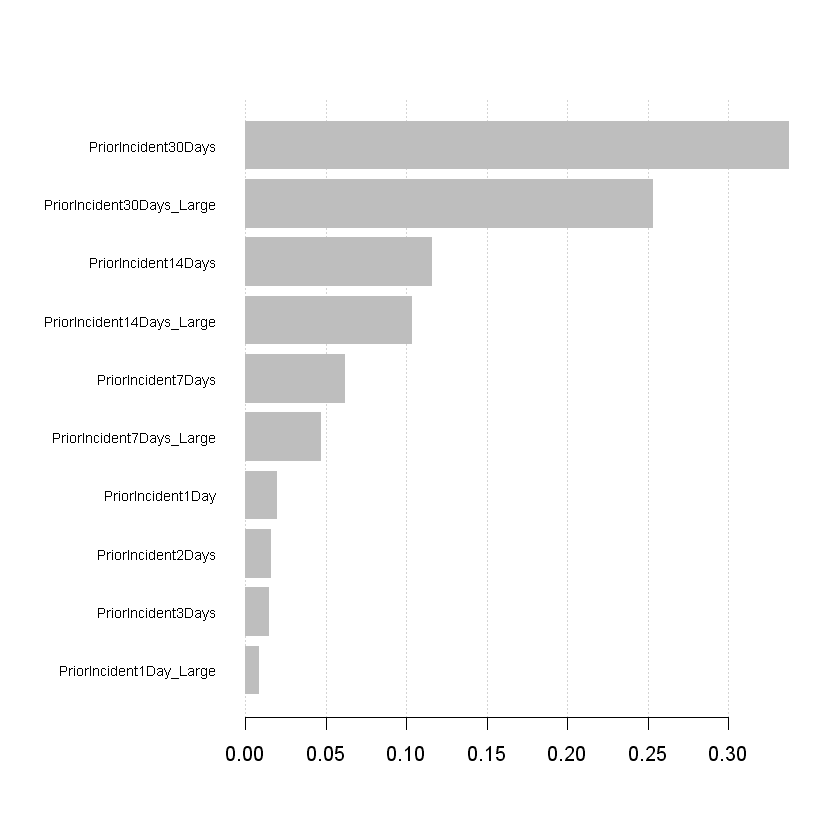

In [6]:
# Compute feature importance matrix
importance_matrix <- xgb.importance(feature.names, model = clf)

# Graph important features
xgb.plot.importance(importance_matrix[1:10,])

It looks like the model it using a combination of small and large grid features to determine if an incident will occur on the current day. It is interesting that the longer term features seem to be more important, indicating a history of criminal activity in the area and surrounding areas.

### Predict on Test and Check ROC Curve
The last step is to check our predictions against the test data set and see how well they did. We always hope that the ROC curve will spike up really high and really quick, but that is not always the case. In our example, we have a decent score with only basic features included in the model. This definitely shows us that we can do the predictions and more time should be invested to make it better.

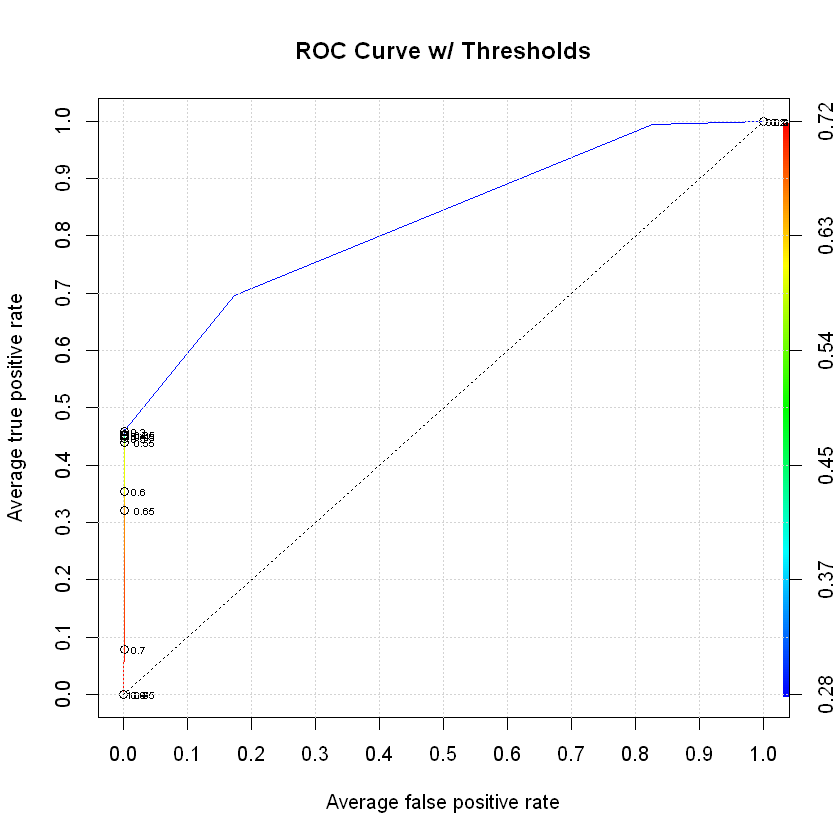

In [8]:
# Predict on test data
preds <- predict(clf, dtest)

# Graph AUC curve
xgb.pred <- prediction(preds, test$target)
xgb.perf <- performance(xgb.pred, "tpr", "fpr")

plot(xgb.perf,
     avg="threshold",
     colorize=TRUE,
     lwd=1,
     main="ROC Curve w/ Thresholds",
     print.cutoffs.at=seq(0, 1, by=0.05),
     text.adj=c(-0.5, 0.5),
     text.cex=0.5)
grid(col="lightgray")
axis(1, at=seq(0, 1, by=0.1))
axis(2, at=seq(0, 1, by=0.1))
abline(v=c(0.1, 0.3, 0.5, 0.7, 0.9), col="lightgray", lty="dotted")
abline(h=c(0.1, 0.3, 0.5, 0.7, 0.9), col="lightgray", lty="dotted")
lines(x=c(0, 1), y=c(0, 1), col="black", lty="dotted")

### Review the Confusion Matrix
We know there is a decent AUC score but let's look at the actual output of what we predicted vs. what actually happened. The easiest way to do this is to review the confusion matrix. We want the top left and bottom right boxes (good predictions) to be big and the others (bad predictions) to be small. 

In [9]:
# Set our cutoff threshold
preds.resp <- ifelse(preds >= 0.5, 1, 0)

# Create the confusion matrix
confusionMatrix(as.factor(preds.resp), as.factor(test$target), positive = "1")


Confusion Matrix and Statistics

          Reference
Prediction      0      1
         0 280581    454
         1     62    367
                                         
               Accuracy : 0.9982         
                 95% CI : (0.998, 0.9983)
    No Information Rate : 0.9971         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.5864         
                                         
 Mcnemar's Test P-Value : < 2.2e-16      
                                         
            Sensitivity : 0.447016       
            Specificity : 0.999779       
         Pos Pred Value : 0.855478       
         Neg Pred Value : 0.998385       
             Prevalence : 0.002917       
         Detection Rate : 0.001304       
   Detection Prevalence : 0.001524       
      Balanced Accuracy : 0.723397       
                                         
       'Positive' Class : 1              
                                

Over the course of 7 days, it looks like there were 821 incidents and our model correctly predicted 367 of them. The other key point is that we incorrectly predicted 62 incidents, essentially sending police officers to areas where we thought a crime could occur but did not. At face value, this doesn't seem too bad but we would need to see how this affect general response times to criminal activity vs. what the current response times are at right now. The idea being that police officers are put in areas close enough to a crime that they can either prevent it with their presence or respond to it very quickly to prevent as much harm as possible.

### Prepare Data for Reporting
Next we can add in the longitude and latitude coordinates for the test data set and export it to a CSV file. This will allow us to take a look at the actual predictions on a map in a BI tool like Tableau.

In [10]:
# Read in the grid coordinates
gridsmall <- sqlQuery(dbhandle, 'select * from gridsmall')

# Merge the predictions with the test data
results <- cbind(test, preds)

# Merge the grid coordinates with the test data
results <- merge(results, gridsmall, by="GridSmallId")

head(results)

# Save to file
write.csv(results,"Data\\CrimePredictions.csv", row.names = TRUE)

GridSmallId,target,GridLargeId.x,DayOfWeek,MonthOfYear,DayOfYear,Year,PriorIncident1Day,PriorIncident2Days,PriorIncident3Days,...,PriorIncident3Days_Large,PriorIncident7Days_Large,PriorIncident14Days_Large,PriorIncident30Days_Large,preds,BotLeftLatitude,TopRightLatitude,BotLeftLongitude,TopRightLongitude,GridLargeId.y
1,0,1,3,2,52,2017,0,0,0,...,0,0,0,0,0.2822689,39.20041,39.20128,-76.71162,-76.7107,1
1,0,1,5,2,54,2017,0,0,0,...,0,0,0,0,0.2822689,39.20041,39.20128,-76.71162,-76.7107,1
1,0,1,7,2,56,2017,0,0,0,...,0,0,0,0,0.2822689,39.20041,39.20128,-76.71162,-76.7107,1
1,0,1,4,2,53,2017,0,0,0,...,0,0,0,0,0.2822689,39.20041,39.20128,-76.71162,-76.7107,1
1,0,1,2,2,58,2017,0,0,0,...,0,0,0,0,0.2822689,39.20041,39.20128,-76.71162,-76.7107,1
1,0,1,1,2,57,2017,0,0,0,...,0,0,0,0,0.2822689,39.20041,39.20128,-76.71162,-76.7107,1


### Visualizing the Predictions
It is time to see what these predictions actually look like over the course of 7 days. The Tableau dashboard itself can be found here: 
- <a href="https://public.tableau.com/profile/jason.wittenauer#!/vizhome/CrimePrediction_15793180506290/CrimeMap">Crime Prediction Dashboard</a>

While looking at the predictions that were incorrect (red dots), it looks like they are pretty close to predictions that were correct. This would put police officers in the general vicinity of a crime occurring. So maybe the incorrect predictions are not affecting the overall results very much at all. An example screenshot is shown below with the correct predictions (blue) and incorrect predictions (red).

#### Incorrect Predictions
<img src="bin/Incorrect Predictions.png">

#### Incorrect and Correct Predictions
<img src="bin/Incorrect and Correct Predictions.png">

Overall it does not seem too bad, but we will need more features and/or more data to capture all those missing predictions. There is probably a lot more we can do to visual the types of crimes that are occuring and try to key in on specific prediction modeling to handle each one different.

### What Next?
This tutorial got us started with doing geographical time series predictions using crime data. We can see that the predictions are definitely working, but there is more work to be done with creating features. We might want to add in some other features that check a larger area for prior crime occurences. Another useful step would be to change our predictions to run hourly and map squad car patrol routes by time of day. Even if the predictions are not perfect, as long as you are putting a police officer in the general vicinity of a crime then they can respond much faster or even prevent it from occurring in the first place with just their presence.